<a href="https://colab.research.google.com/github/KathituCodes/5G-Energy-Consumption-Machine-Learning-Challenge/blob/main/5G_Energy_Consumption_Modeling_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1: Load and Explore the Dataset**

---

## ***A. Display general information about the dataset***

In [108]:
!pip install ydata-profiling --upgrade

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import seaborn as sns
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [109]:
# Load the dataset
file_path = '/content/5G_energy_consumption_dataset.csv'
data = pd.read_csv(file_path)

In [110]:
# Display the head of the data
data.head()

Time   BS     Energy      load  ESMODE   TXpower
0  20230101 010000  B_0  64.275037  0.487936     0.0  7.101719
1  20230101 020000  B_0  55.904335  0.344468     0.0  7.101719
2  20230101 030000  B_0  57.698057  0.193766     0.0  7.101719
3  20230101 040000  B_0  55.156951  0.222383     0.0  7.101719
4  20230101 050000  B_0  56.053812  0.175436     0.0  7.101719

In [111]:
# Display general information about the dataset
data.info()
print("---------------------------------------")

print("---------------------------------------")
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92629 entries, 0 to 92628
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Time     92629 non-null  object 
 1   BS       92629 non-null  object 
 2   Energy   92629 non-null  float64
 3   load     92629 non-null  float64
 4   ESMODE   92629 non-null  float64
 5   TXpower  92629 non-null  float64
dtypes: float64(4), object(2)
memory usage: 4.2+ MB
---------------------------------------
---------------------------------------


Energy          load        ESMODE       TXpower
count  92629.000000  92629.000000  92629.000000  92629.000000
mean      28.138997      0.244705      0.081361      6.765427
std       13.934645      0.234677      0.382317      0.309929
min        0.747384      0.000000      0.000000      5.381166
25%       18.236173      0.057370      0.000000      6.427504
50%       24.065770      0.165550      0.000000      6.875934
75%       35.724963      0.363766      0.000000      6.875934
max      100.000000      0.993957      4.000000      8.375336

The dataset contains 92,629 entries and 6 columns. The columns are `Time`, `BS`, `Energy`, `load`, `ESMODE`, and `TXpower`.

## ***B. Create a pandas profiling reports to gain insights into the dataset***
Let's generate the pandas profiling report for more insights.

In [112]:
from ydata_profiling import ProfileReport
# Generate a profiling report
profile_report = ProfileReport(data, title="Pandas Profiling Report", explorative=True)
profile_report.to_notebook_iframe()

# Generate the profiling report
profile_report.to_file("pandas_profiling_report.html")



Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 6/6 [00:00<00:00,  7.99it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## ***C. Handle Missing and corrupted values***

The next thing I did was to identify and handle any missing or corrupted values in the dataset.

In [113]:
# Handle missing values
# Separate numeric and non-numeric columns
numeric_cols = data.select_dtypes(include=['number']).columns
non_numeric_cols = data.select_dtypes(exclude=['number']).columns

# Fill missing values in numeric columns with mean
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())

# Fill missing values in non-numeric columns with mode
for col in non_numeric_cols:
    data[col] = data[col].fillna(data[col].mode()[0])

# Check again for missing values
missing_values_cleaned = data.isnull().sum()
print("Missing values after cleaning:\n", missing_values_cleaned)

Missing values after cleaning:
 Time       0
BS         0
Energy     0
load       0
ESMODE     0
TXpower    0
dtype: int64


There are no missing values in the dataset. Therefore, I do not need to handle any missing values.






## ***D. Remove duplicates, if they exist***
Let's check for duplicates and remove them if they exist.

In [114]:
# Check for duplicates
duplicates = data.duplicated().sum()

# Remove duplicates
data_cleaned = data.drop_duplicates()

duplicates_removed = (duplicates, data_cleaned.duplicated().sum())
duplicates_removed

(np.int64(0), np.int64(0))

There are no Dupliclates

## ***E. Handle Outliers***
I then checked to detect and handle outliers in the dataset. To determine the best approach for handling outliers in the 5G energy consumption dataset, I need to consider the nature of the data and the specific characteristics of 5G network energy consumption.

### **1. Load the set & Define helper functions**

These functions are designed to identify, plot, and handle outliers using multiple methods.

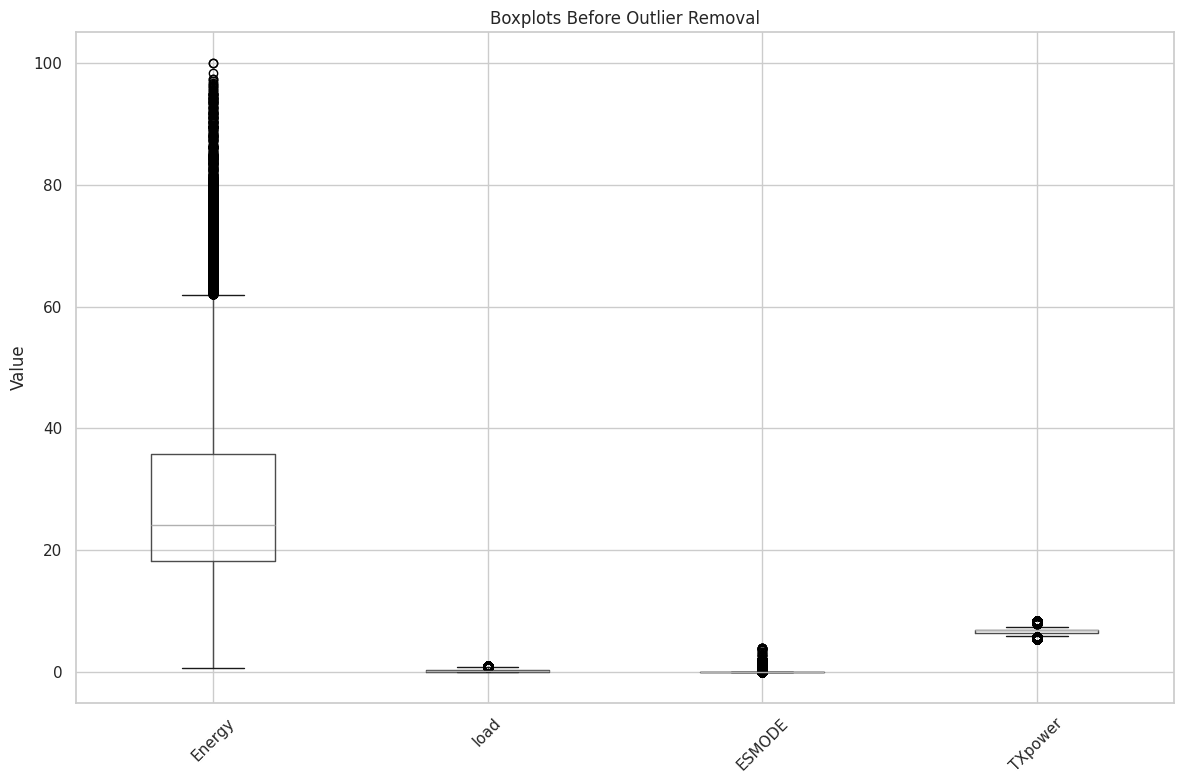

In [115]:

# Set plot style
sns.set(style="whitegrid")

# Select only numeric columns for boxplots
numeric_cols = ['Energy', 'load', 'ESMODE', 'TXpower']

# Create initial boxplots before outlier handling
plt.figure(figsize=(12, 8))
data[numeric_cols].boxplot()
plt.title('Boxplots Before Outlier Removal')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


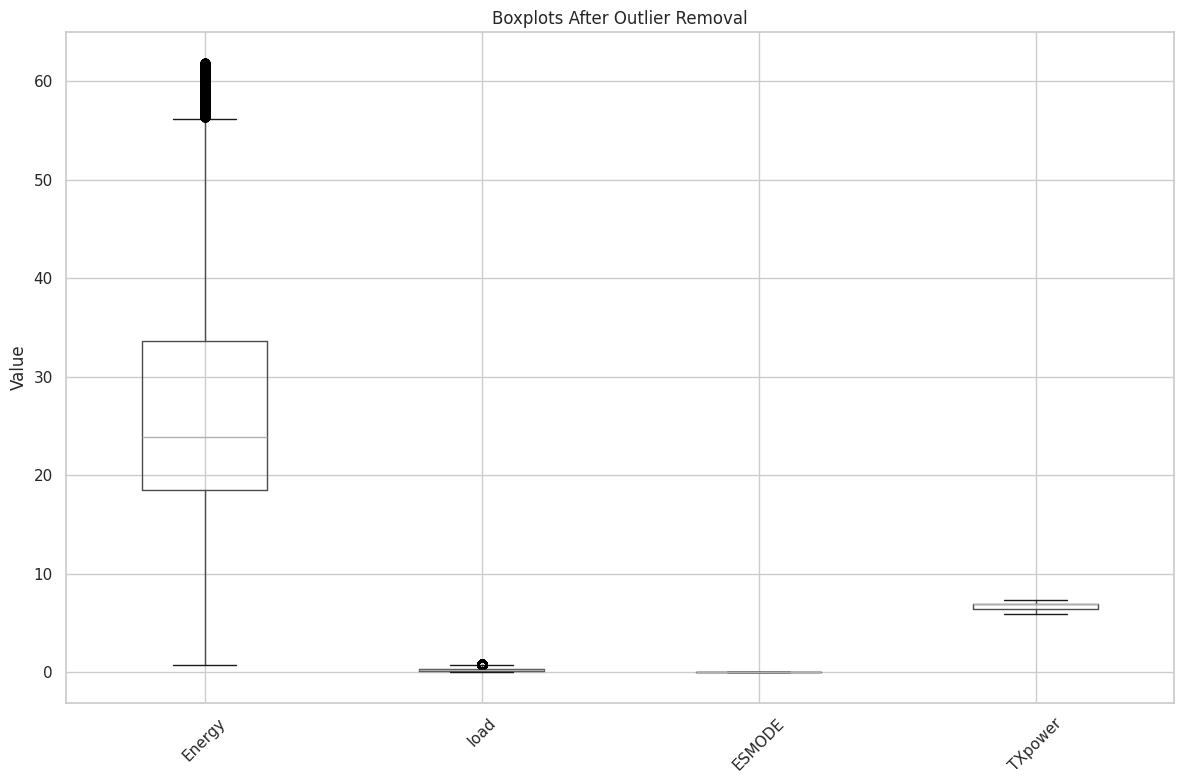

In [116]:
# Function to remove outliers using the IQR method
def remove_outliers_iqr(data, columns):
    cleaned_data = data.copy()
    for col in columns:
        Q1 = cleaned_data[col].quantile(0.25)
        Q3 = cleaned_data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        cleaned_data = cleaned_data[(cleaned_data[col] >= lower_bound) & (cleaned_data[col] <= upper_bound)]
    return cleaned_data

# Remove outliers from numeric columns
data_cleaned = remove_outliers_iqr(data, numeric_cols)

# Create boxplots after outlier handling
plt.figure(figsize=(12, 8))
data_cleaned[numeric_cols].boxplot()
plt.title('Boxplots After Outlier Removal')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## **F. Exploratory Data Analysis (EDA):**
Here, I perform a thorough EDA to understand the distribution and characteristics of the data. It provides a summary of the dataset, creates histograms, and generates Q-Q plots for each numeric column. This helps in understanding the data distribution and potential outliers.

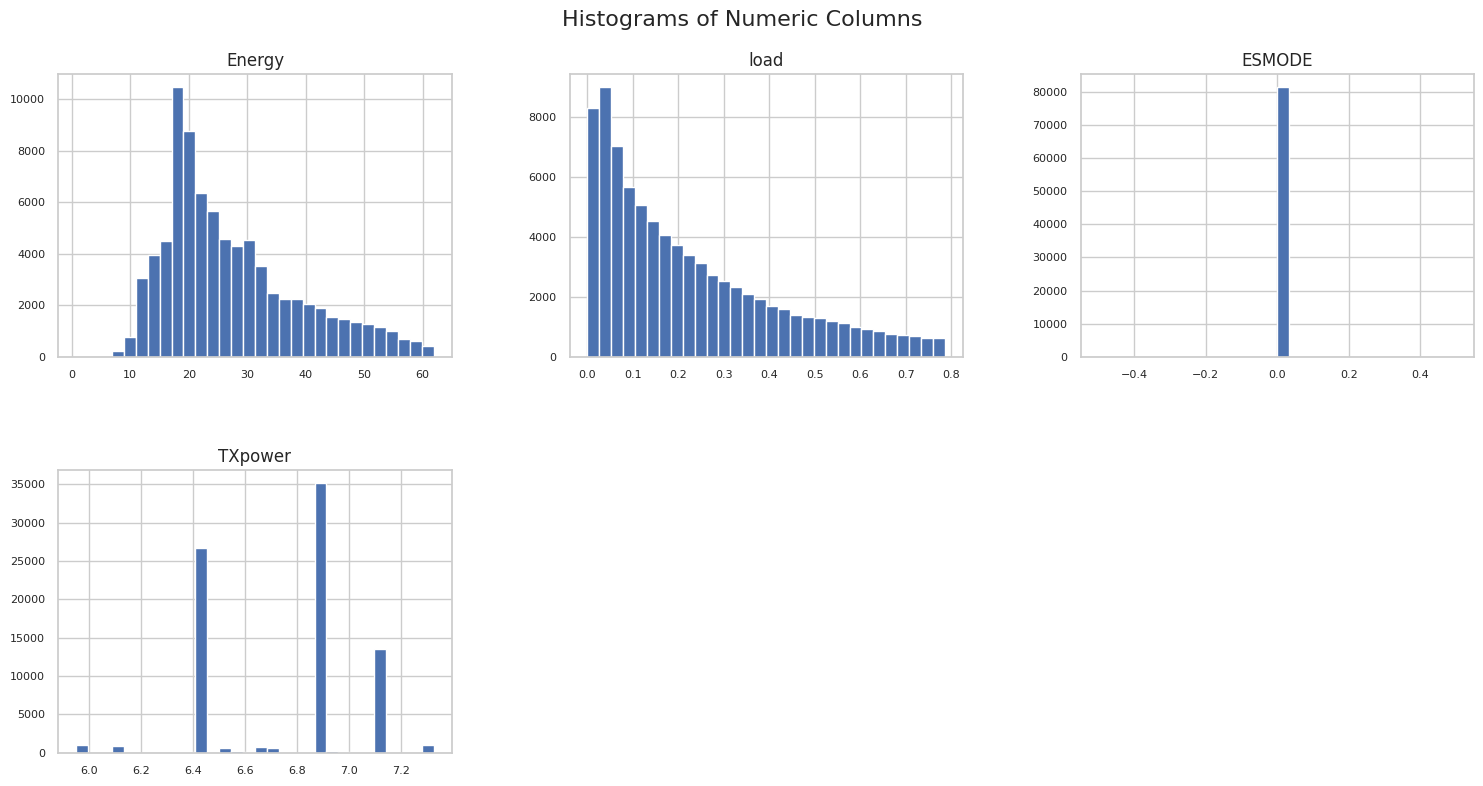

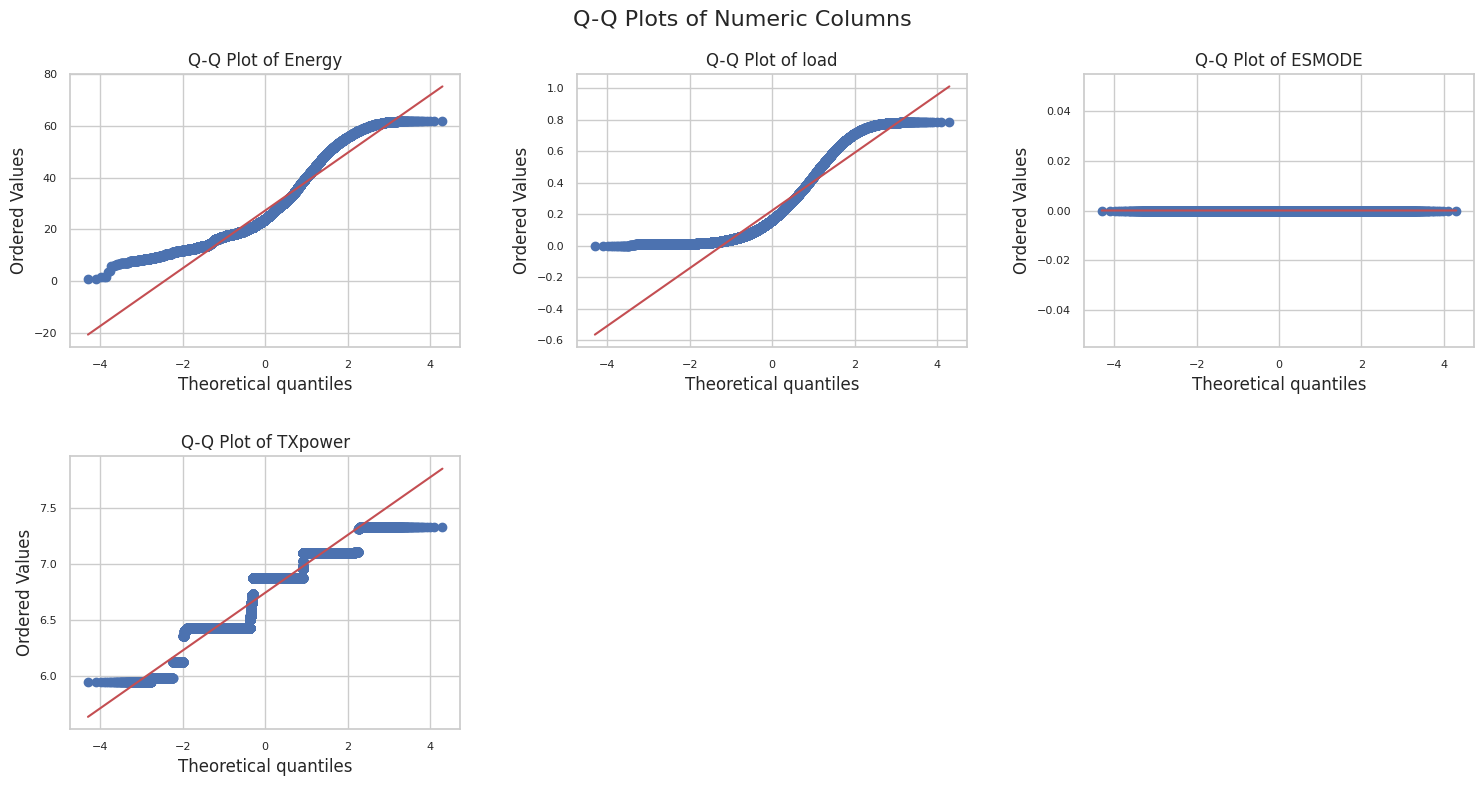

In [117]:
# Print descriptive statistics
data_cleaned.describe()

# Get numeric columns
numeric_columns = data_cleaned.select_dtypes(include=[np.number]).columns
n_cols = len(numeric_columns)

# Calculate number of rows and columns for subplots
n_rows = (n_cols + 2) // 3  # This ensures we have enough rows
n_cols_plot = min(3, n_cols)  # This ensures we don't have more than 3 columns

# Create histograms
fig, axes = plt.subplots(n_rows, n_cols_plot, figsize=(5*n_cols_plot, 4*n_rows))
fig.suptitle('Histograms of Numeric Columns', fontsize=16)

for i, column in enumerate(numeric_columns):
    row = i // 3
    col = i % 3
    ax = axes[row, col] if n_rows > 1 else axes[col]
    ax.hist(data_cleaned[column], bins=30)
    ax.set_title(column)
    ax.tick_params(axis='both', which='major', labelsize=8)

# Remove any unused subplots
for i in range(n_cols, n_rows * n_cols_plot):
    row = i // 3
    col = i % 3
    fig.delaxes(axes[row, col] if n_rows > 1 else axes[col])

plt.tight_layout()
plt.subplots_adjust(top=0.9, hspace=0.4, wspace=0.3)
plt.show()

# Create Q-Q plots
fig, axes = plt.subplots(n_rows, n_cols_plot, figsize=(5*n_cols_plot, 4*n_rows))
fig.suptitle('Q-Q Plots of Numeric Columns', fontsize=16)

for i, column in enumerate(numeric_columns):
    row = i // 3
    col = i % 3
    ax = axes[row, col] if n_rows > 1 else axes[col]
    stats.probplot(data_cleaned[column], dist="norm", plot=ax)
    ax.set_title(f"Q-Q Plot of {column}")
    ax.tick_params(axis='both', which='major', labelsize=8)

# Remove any unused subplots
for i in range(n_cols, n_rows * n_cols_plot):
    row = i // 3
    col = i % 3
    fig.delaxes(axes[row, col] if n_rows > 1 else axes[col])

plt.tight_layout()
plt.subplots_adjust(top=0.9, hspace=0.4, wspace=0.3)
plt.show()

### 📈 Histogram Plot :
### **1. Energy**

* **Shape**: Right-skewed (long tail to the right)
* **Interpretation**: Most values are clustered around 15–25, but a few go much higher.

---

### **2. load**

* **Shape**: Strongly right-skewed
* **Interpretation**: Most values are near 0; very few approach 1.

---

### **3. ESMODE**

* **Shape**: Extremely skewed with a spike at 0
* **Interpretation**: Likely has many zero values and a few distinct non-zero categories.

---

### **4. TXpower**

* **Shape**: Discrete peaks, possibly at fixed power levels
* **Interpretation**: Looks like it's set to **specific power values** (e.g., 6.5, 7.0, etc.).

---

### ✅ Summary:

* **None of these variables are normally distributed**.


## **G. Identify and visualize outliers**
Here we identify and visualize outliers for each numeric column using multiple methods.


Outliers in Energy:
IQR method: 1554
Z-score method: 0
Modified Z-score method: 1505


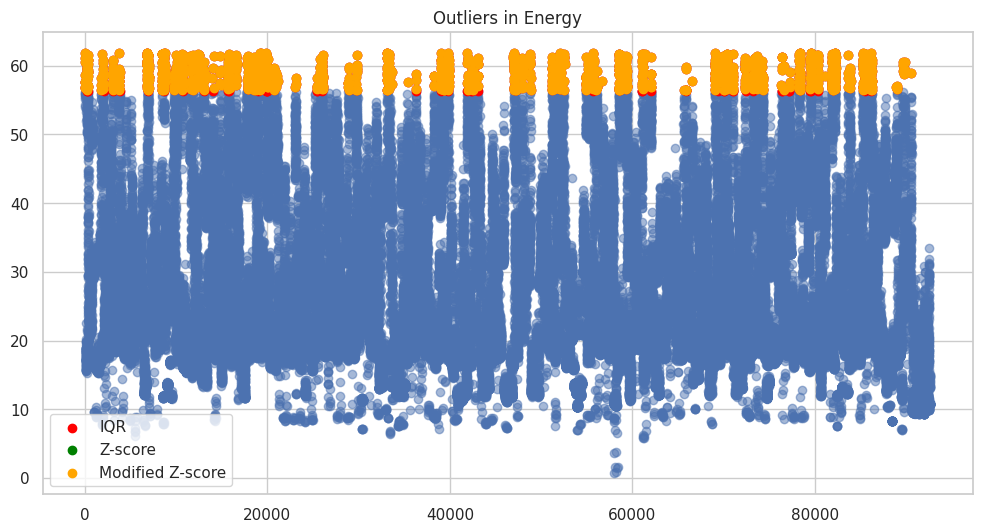


Outliers in load:
IQR method: 986
Z-score method: 0
Modified Z-score method: 269


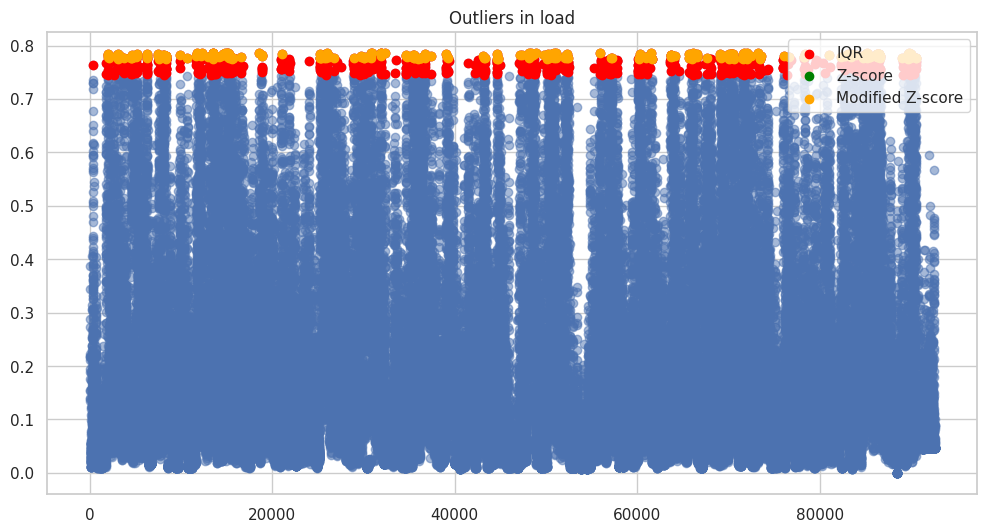


Outliers in ESMODE:
IQR method: 0
Z-score method: 0
Modified Z-score method: 0


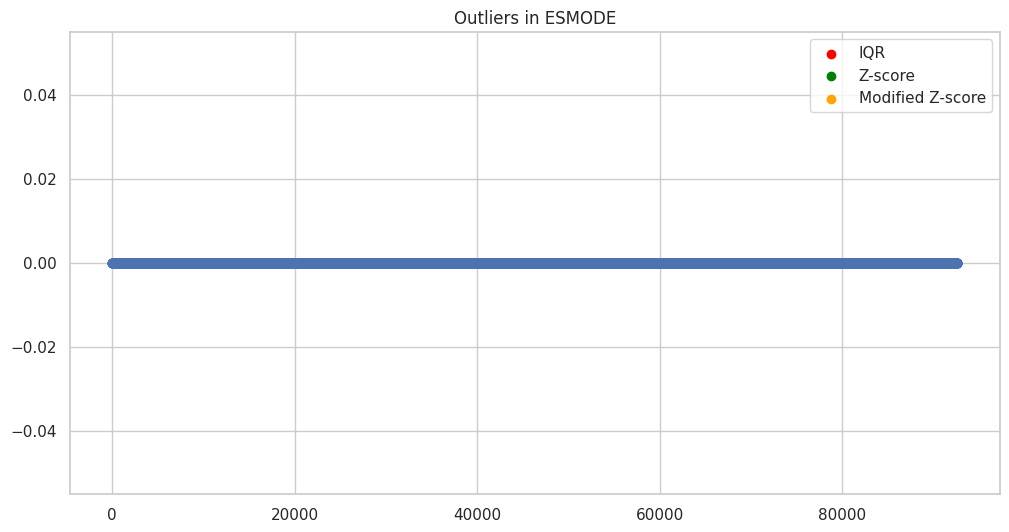


Outliers in TXpower:
IQR method: 0
Z-score method: 0
Modified Z-score method: 0


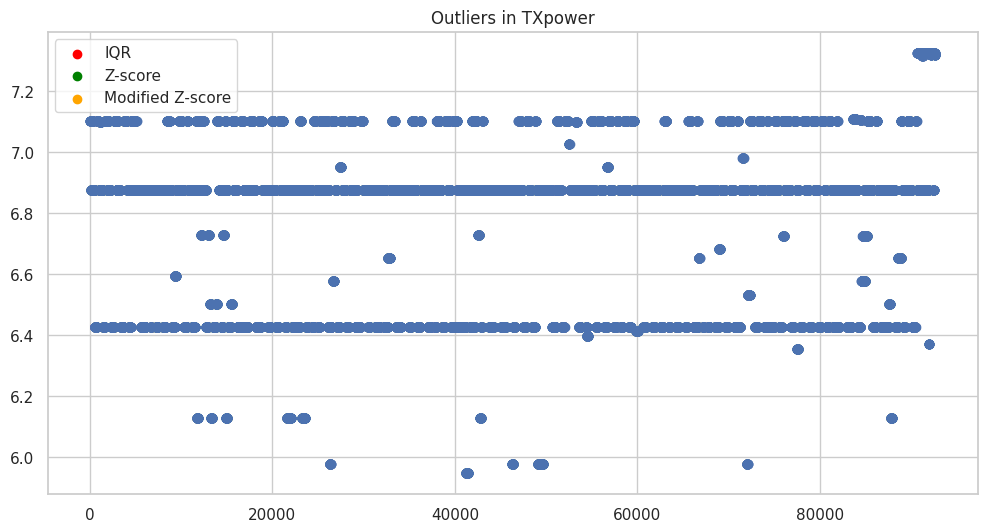

In [118]:
for column in data_cleaned.select_dtypes(include=[np.number]).columns:
    iqr, z, mod_z = identify_outliers(data_cleaned, column)
    print(f"\nOutliers in {column}:")
    print(f"IQR method: {len(iqr)}")
    print(f"Z-score method: {len(z)}")
    print(f"Modified Z-score method: {len(mod_z)}")
    plot_outliers(data_cleaned, column)

## **H. Handle outliers - Mitigating Impact of Extreme Values**

- Energy consumption might have natural fluctuations based on network load.
There could be legitimate spikes during high-traffic periods.
Some extreme values might represent real events rather than errors.
- Multiple outlier detection methods:
Use a combination of methods to identify potential outliers.

In [119]:
from tabulate import tabulate

data_no_outliers = data_cleaned.copy()
for column in data_cleaned.select_dtypes(include=[np.number]).columns:
    data_no_outliers = handle_outliers(data_no_outliers, column, method='cap')

# Compare shapes
shapes = [
    ["Original", data_cleaned.shape[0], data_cleaned.shape[1]],
    ["After handling outliers", data_no_outliers.shape[0], data_no_outliers.shape[1]]
]
print(tabulate(shapes, headers=["Dataset", "Rows", "Columns"], tablefmt="grid"))

# Compare summary statistics
print("\nBefore outlier handling:")
print(tabulate(data_cleaned.describe().T, headers="keys", tablefmt="grid", floatfmt=".2f"))

print("\nAfter outlier handling:")
print(tabulate(data_no_outliers.describe().T, headers="keys", tablefmt="grid", floatfmt=".2f"))

# Count the number of changes
changes = (data_cleaned != data_no_outliers).sum()
changes_table = [[column, count] for column, count in changes.items()]
print("\nNumber of values changed in each column:")
print(tabulate(changes_table, headers=["Column", "Changes"], tablefmt="grid"))

+-------------------------+--------+-----------+
| Dataset                 |   Rows |   Columns |
+=========================+========+===========+
| Original                |  81228 |         6 |
+-------------------------+--------+-----------+
| After handling outliers |  81228 |         6 |
+-------------------------+--------+-----------+

Before outlier handling:
+---------+----------+--------+-------+-------+-------+-------+-------+-------+
|         |    count |   mean |   std |   min |   25% |   50% |   75% |   max |
+=========+==========+========+=======+=======+=======+=======+=======+=======+
| Energy  | 81228.00 |  27.28 | 11.61 |  0.75 | 18.54 | 23.92 | 33.63 | 61.88 |
+---------+----------+--------+-------+-------+-------+-------+-------+-------+
| load    | 81228.00 |   0.22 |  0.19 |  0.00 |  0.06 |  0.16 |  0.34 |  0.79 |
+---------+----------+--------+-------+-------+-------+-------+-------+-------+
| ESMODE  | 81228.00 |   0.00 |  0.00 |  0.00 |  0.00 |  0.00 |  0.00 |

### **The Cap Method**
Instead of removing outliers, I decided to cap them at the 1st and 99th percentiles. This is a good choice for 5G energy consumption data, as it preserves data points while mitigating the impact of extreme values.


In [120]:
nan_rows = data_no_outliers[data_no_outliers.isnull().any(axis=1)]
print(nan_rows)

Empty DataFrame
Columns: [Time, BS, Energy, load, ESMODE, TXpower]
Index: []


In [121]:
print(data_no_outliers.isnull().sum())

Time       0
BS         0
Energy     0
load       0
ESMODE     0
TXpower    0
dtype: int64


## **I. Encode Categorical Features**
Encode non-numeric columns using techniques like label encoding or one-hot encoding.

In [122]:
from sklearn.preprocessing import LabelEncoder

# Identify categorical features
categorical_features = data_no_outliers.select_dtypes(include=['object']).columns

# Apply label encoding
label_encoders = {}
for feature in categorical_features:
    label_encoders[feature] = LabelEncoder()
    data_no_outliers[feature] = label_encoders[feature].fit_transform(data_no_outliers[feature])

encoded_data_head = data_no_outliers.head()
encoded_data_head

Time  BS     Energy      load  ESMODE   TXpower
1      1   0  55.904335  0.344468     0.0  7.101719
2      2   0  57.698057  0.193766     0.0  7.101719
3      3   0  55.156951  0.222383     0.0  7.101719
4      4   0  56.053812  0.175436     0.0  7.101719
20    25   0  55.754858  0.210952     0.0  7.101719

# **2. Building the Machine Learning Model**

---

Select Target Variable and Features

In [123]:
# Select target variable and features
target_variable = 'Energy'
features = data_no_outliers.drop(columns=[target_variable])
target = data_no_outliers[target_variable]

features.head(), target.head()

(    Time  BS      load  ESMODE   TXpower
 1      1   0  0.344468     0.0  7.101719
 2      2   0  0.193766     0.0  7.101719
 3      3   0  0.222383     0.0  7.101719
 4      4   0  0.175436     0.0  7.101719
 20    25   0  0.210952     0.0  7.101719,
 1     55.904335
 2     57.698057
 3     55.156951
 4     56.053812
 20    55.754858
 Name: Energy, dtype: float64)

This will give a good overview of the features and target, including data types, basic statistics, and correlations with the target variable. This information can be valuable for feature selection and engineering in the next steps.

In [124]:
print("Features:")
print(features.info())
print("\nFeature descriptions:")
print(features.describe())

print("\nTarget variable:")
print(target.describe())

# Check for any remaining categorical variables
categorical_features = features.select_dtypes(include=['object']).columns
print("\nRemaining categorical features:", categorical_features.tolist())

# Correlation with target
correlation_with_target = features.corrwith(target).sort_values(ascending=False)
print("\nCorrelation with target variable:")
print(correlation_with_target)

Features:
<class 'pandas.core.frame.DataFrame'>
Index: 81228 entries, 1 to 92628
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Time     81228 non-null  int64  
 1   BS       81228 non-null  int64  
 2   load     81228 non-null  float64
 3   ESMODE   81228 non-null  float64
 4   TXpower  81228 non-null  float64
dtypes: float64(3), int64(2)
memory usage: 3.7 MB
None

Feature descriptions:
               Time            BS          load   ESMODE       TXpower
count  81228.000000  81228.000000  81228.000000  81228.0  81228.000000
mean      71.732506    415.724664      0.223621      0.0      6.743235
std       44.276983    241.030451      0.194306      0.0      0.279885
min        0.000000      0.000000      0.009637      0.0      5.979073
25%       34.000000    206.000000      0.062959      0.0      6.427504
50%       67.000000    419.000000      0.164056      0.0      6.875934
75%      109.000000    622.000000      0.33571

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


`Energy` has a high correlation to the rest of the variables.

# **3. Split the Dataset into Training and Test Sets**

---

## ***Data Splitting***

In this section, we split our data into training and test sets.

In [125]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("Training target shape:", y_train.shape)
print("Testing target shape:", y_test.shape)

print("\nProportion of data in training set: {:.2f}".format(len(X_train) / len(features)))
print("Proportion of data in test set: {:.2f}".format(len(X_test) / len(features)))

Training set shape: (64982, 5)
Testing set shape: (16246, 5)
Training target shape: (64982,)
Testing target shape: (16246,)

Proportion of data in training set: 0.80
Proportion of data in test set: 0.20


### ***Feature Scaling***

Feature scaling is an essential preprocessing step in many machine learning algorithms. In this section, we use StandardScaler to scale our features. Here's why this step is important:

1. Uniform Scale: Different features often have different scales. For example, one feature might range from 0 to 1, while another ranges from 0 to 1000. Scaling ensures all features are on a similar scale, typically with a mean of 0 and a standard deviation of 1.

2. Model Performance: Many machine learning algorithms perform better or converge faster when features are on a similar scale.

3. Feature Importance: When features are on different scales, it can be difficult to interpret their importance. Scaling allows for fair comparison between features.

4. Preventing Dominance: Without scaling, features with larger values might dominate the model training process, even if they're not more important for predicting the target variable.

5. Numerical Stability: Some algorithms can become numerically unstable when dealing with features of vastly different scales.

In [126]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

We use StandardScaler, which standardizes features by removing the mean and scaling to unit variance. The transformation is given by:

z = (x - u) / s

where u is the mean of the training samples, and s is the standard deviation of the training samples.

Note that we fit the scaler on the training data and then use it to transform both the training and test data. This is crucial to prevent data leakage - we don't want information from the test set influencing the scaling of our training data.

By applying StandardScaler:
- X_train_scaled: The scaled training features
- X_test_scaled: The scaled test features

These scaled datasets will be used for training and evaluating our models, ensuring that all features contribute equally to the model's learning process.

# **4. Select a Machine Learning Regression Algorithm and Train It**

---


### ***Model Training and Evaluation***

Here, we train multiple models and evaluate their performance.

In [127]:
# Select and train multiple models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    # Train the model
    model.fit(X_train_scaled, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results[name] = {"RMSE": rmse, "R2": r2}

Now lets present the findings in a table.

In [128]:
# Present results in a table
table_data = [[name, f"{metrics['RMSE']:.4f}", f"{metrics['R2']:.4f}"] for name, metrics in results.items()]

print("\nModel Evaluation Results:")
print(tabulate(table_data, headers=["Model", "RMSE", "R2 Score"], tablefmt="grid"))

# Print the best model
best_model = min(results, key=lambda x: results[x]['RMSE'])
print(f"\nBest Model based on RMSE: {best_model}")


Model Evaluation Results:
+-------------------+--------+------------+
| Model             |   RMSE |   R2 Score |
+===================+========+============+
| Linear Regression | 8.3676 |     0.4696 |
+-------------------+--------+------------+
| Ridge Regression  | 8.3676 |     0.4696 |
+-------------------+--------+------------+
| Lasso Regression  | 8.4723 |     0.4563 |
+-------------------+--------+------------+
| Random Forest     | 2.7883 |     0.9411 |
+-------------------+--------+------------+

Best Model based on RMSE: Random Forest


## ***Visualization of Model Performance Metrics***

In this section, I visualized the performance metrics (RMSE and R2 Score) for each model I trained. This helps us quickly compare the performance of different models.

### ***Root Mean Square Error (RMSE)***

The first plot shows the RMSE for each model. RMSE is a measure of the differences between predicted values and observed values. It represents the standard deviation of the residuals (prediction errors). Lower RMSE values indicate better model performance.

- A lower RMSE indicates that the model's predictions are closer to the actual values.
- RMSE is in the same units as the target variable, making it interpretable in the context of the data.

### ***R2 Score (Coefficient of Determination)***

The second plot shows the R2 Score for each model. R2 Score represents the proportion of the variance in the dependent variable that is predictable from the independent variables.

- R2 Score ranges from 0 to 1, where 1 indicates perfect prediction.
- A higher R2 Score suggests that the model explains more of the variability in the data.

These visualizations allow us to:

1. Compare the performance of different models at a glance.
2. Identify which models are performing best in terms of RMSE and R2 Score.
3. Assess if there's a significant difference in performance between models.

By examining both RMSE and R2 Score, we get a more comprehensive view of each model's performance. While RMSE gives us an idea of the average prediction error, R2 Score tells us how well the model explains the variance in the target variable.

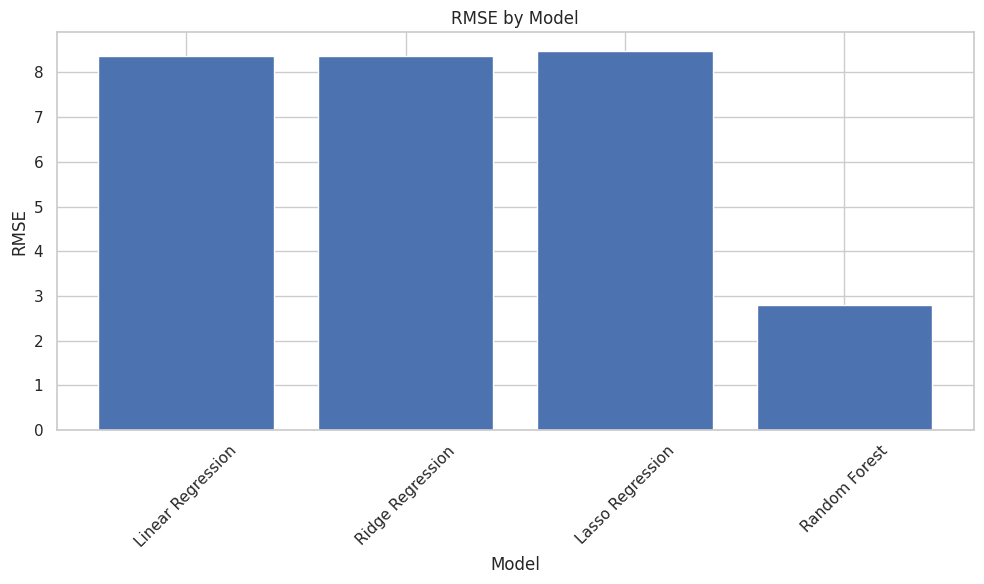

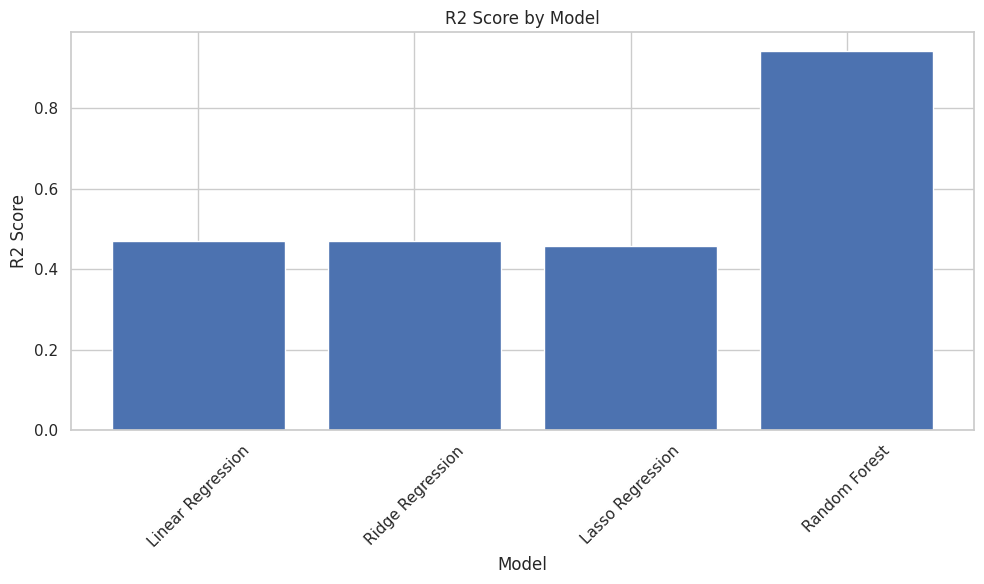

In [129]:
# Visualize RMSE by model
plt.figure(figsize=(10, 6))
plt.bar(results.keys(), [metrics['RMSE'] for metrics in results.values()])
plt.title('RMSE by Model')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualize R2 Score by model
plt.figure(figsize=(10, 6))
plt.bar(results.keys(), [metrics['R2'] for metrics in results.values()])
plt.title('R2 Score by Model')
plt.xlabel('Model')
plt.ylabel('R2 Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## **Scatter plot of predicted vs actual values for the best model**

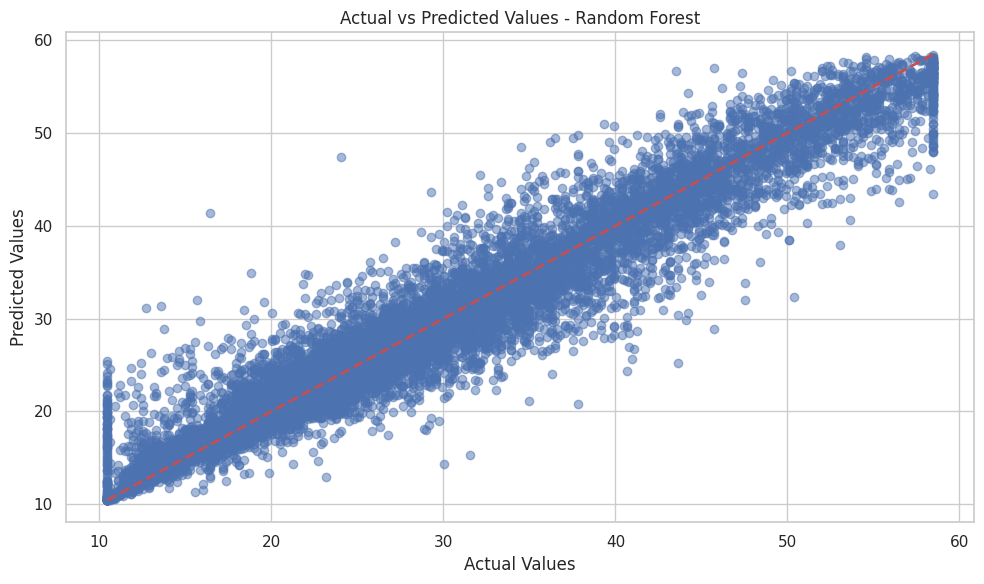

In [130]:
# Scatter plot of predicted vs actual values for the best model# Scatter plot of predicted vs actual values for the best model
best_model_name = min(results, key=lambda x: results[x]['RMSE'])
best_model = models[best_model_name]

y_pred = best_model.predict(X_test_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Actual vs Predicted Values - {best_model_name}')
plt.tight_layout()
plt.show()

## **Random Forest: Best Performing Model**

Our analysis has identified Random Forest as the best performing model for this dataset. .

### Why Random Forest Performed Best

1. Handling Non-linearity: Random Forest can capture non-linear relationships between features and the target variable. If our 5G energy consumption data has complex, non-linear patterns, Random Forest is well-suited to model these.

2. *Feature Interactions:* Random Forest naturally accounts for feature interactions. In 5G systems, there might be complex interactions between different factors affecting energy consumption.

3. *Robustness to Outliers:* Random Forest is generally robust to outliers and noise in the data, which can be common in real-world energy consumption data.

4. *No Assumption of Data Distribution:* Unlike linear models, Random Forest doesn't assume a particular distribution of the target variable or the features.

5. *Handling High-Dimensional Data:* If our dataset has many features, Random Forest can handle high-dimensional data well without overfitting.

### Implications for 5G Energy Consumption Prediction

1. *Complex Relationships:* The superior performance of Random Forest suggests that the relationships between various factors and energy consumption in 5G systems are complex and possibly non-linear.

2. *Feature Importance:* Random Forest allows us to assess feature importance, which can provide insights into which factors most significantly influence 5G energy consumption.

3. *Predictive Power:* The model's high performance indicates that we can make relatively accurate predictions of energy consumption based on the available features for `Energy`.

### ***If the best model is Random Forest, visualize feature importance***

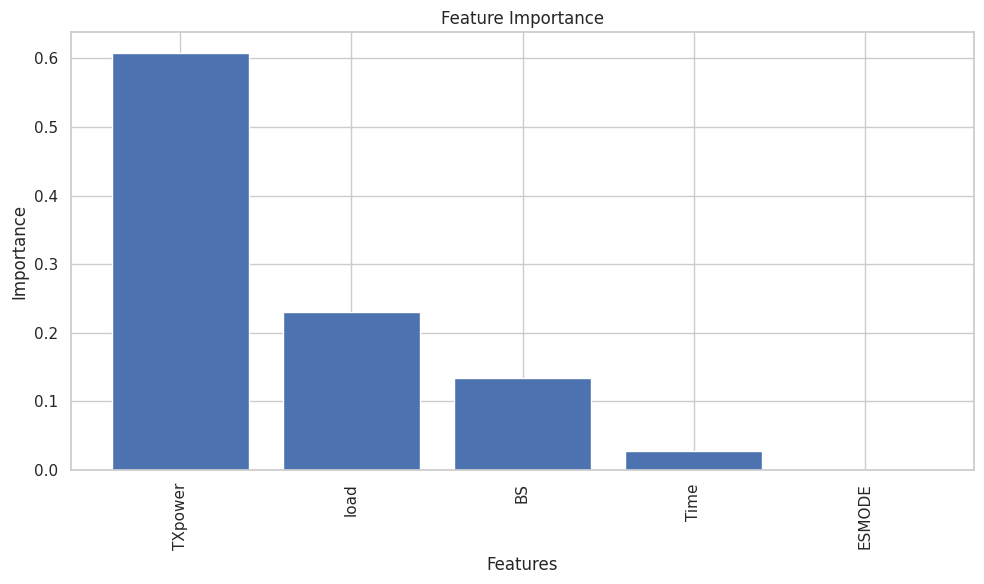

In [131]:
if isinstance(best_model, RandomForestRegressor):
    importances = best_model.feature_importances_
    feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    plt.bar(feature_importances['feature'], feature_importances['importance'])
    plt.title('Feature Importance')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

## **Residual Analysis**

Residual analysis is crucial for validating our model's assumptions and assessing its performance. Here's why it's important:

1. *Model Assumptions:* The residual plot helps us check if the model's assumptions (like homoscedasticity) are met.

2. *Bias Detection:* It can reveal if our model is consistently over or under-predicting in certain ranges.

3. *Outliers:* We can identify potential outliers or influential points that our model struggles with.

4. *Error Distribution:* The histogram of residuals shows if prediction errors are normally distributed, which is ideal for many statistical tests.

5. *Model Adequacy:* If patterns appear in the residuals, it suggests our model might be missing important trends in the data.

By examining these plots, we can assess if our Random Forest model is capturing the underlying patterns in the 5G energy consumption data effectively, or if there are areas where it could be improved.

### ***Residual analysis for the best model***

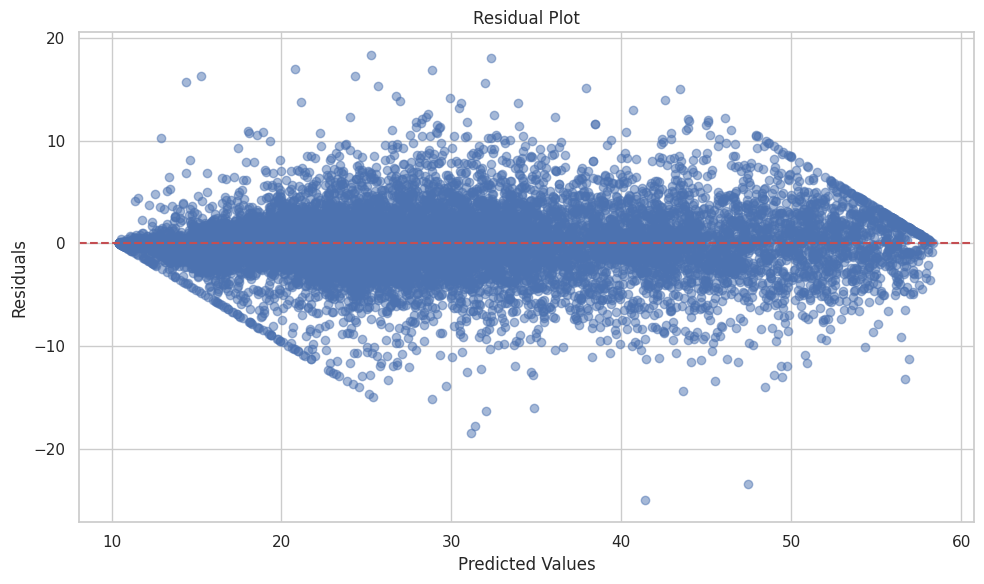

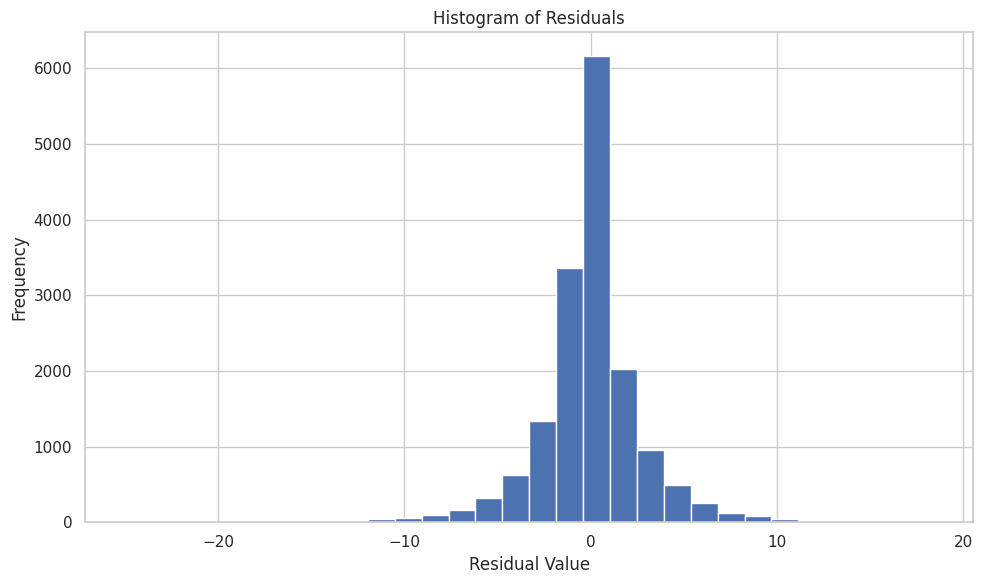

In [132]:
# Residual analysis for the best model
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30)
plt.title('Histogram of Residuals')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()